# とにかく Numpyro に慣れるためのノート

In [1]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
# cpu がどんな感じで動いているか？
jax.devices()

[CpuDevice(id=0)]

In [3]:
data = pd.DataFrame({

    'yield':[7, 13, 13, 11, 5, 6, 8, 11, 10, 11, 11, 11, 11, 14, 8, 15, 10, 9, 13, 12, 8, 15, 7, 11, 5, 11,
             15, 10, 13, 9, 8, 12, 13, 6, 8, 5, 13, 8, 5, 10, 18, 9, 7, 12, 11, 5, 9, 10, 13, 13, 7, 12, 8, 16, 10,
             6, 12, 13, 10, 12, 9, 7, 12, 11, 8, 15, 13, 11, 9, 17, 11, 10, 15, 19, 11, 13, 12, 9, 10, 10],
    'group':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
             1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

})

In [4]:
y = data['yield'].values

In [5]:
np.mean(y)

10.575

In [6]:
np.var(y)

9.319374999999999

### ポイント
平均と分散が同じくらいだからおそらくポワソン分布っぽいね

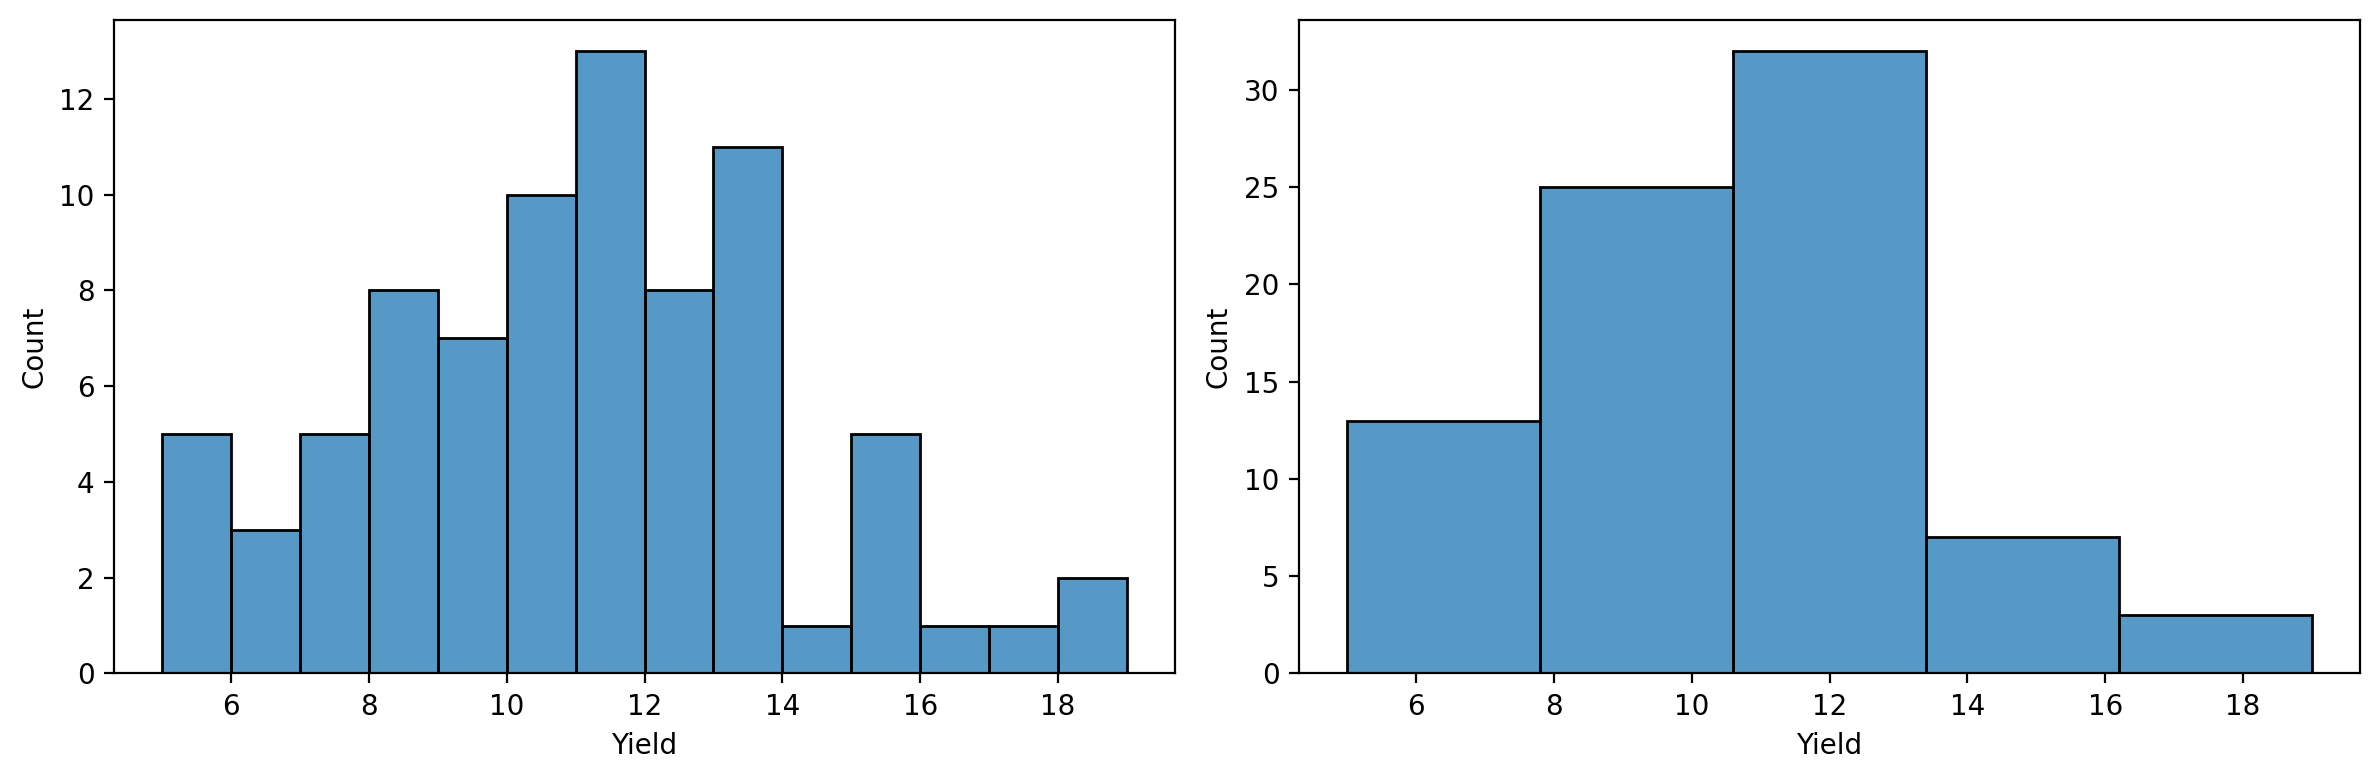

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(y, binwidth = 1, ax = axes[0])
axes[0].set_xlabel('Yield')

sns.histplot(y, binwidth = 3, ax = axes[1])
axes[1].set_xlabel('Yield')

plt.tight_layout()

## モデル定義

In [8]:
def model(y = None, num_data = 0):
    # パラメーターの事前分布
    mu = numpyro.sample('mu', dist.HalfNormal(10))
    # 観測データに基づく尤度の定義
    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Poisson(mu), obs = y)

In [9]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)

mcmc.run(jax.random.PRNGKey(0), y = y, num_data = len(y))

/var/folders/03/smvv0jp54c5cnt0xtqz_1gkc0000gn/T/ipykernel_86750/1028543152.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)
sample: 100%|█| 3500/3500 [00:00<00:00, 3993.00it/s, 3 steps of size 1.08e+00. acc. prob=0
sample: 100%|█| 3500/3500 [00:00<00:00, 12697.53it/s, 3 steps of size 9.90e-01. acc. prob=
sample: 100%|█| 3500/3500 [00:00<00:00, 12664.14it/s, 1 steps of size 9.29e-01. acc. prob=
sample: 100%|█| 3500/3500 [00:00<00:00, 12777.70it/s, 3 steps of size 1.05e+00. acc. prob=


In [10]:
mcmc_samples = mcmc.get_samples()

In [11]:
mcmc_samples

{'mu': Array([10.481569, 10.664241,  9.584686, ..., 10.268413, 10.973196,
        10.684784], dtype=float32)}

In [12]:
# inference data object に変換
idata = az.from_numpyro(mcmc)

In [13]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

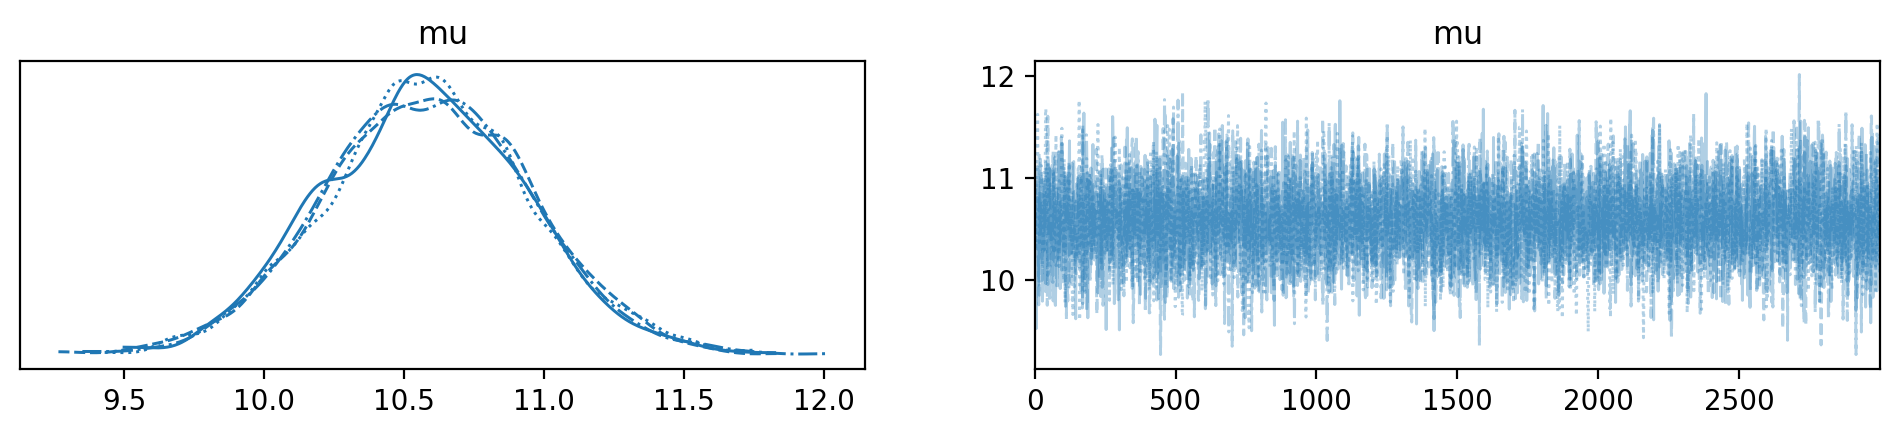

In [14]:
az.plot_trace(idata)

In [15]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,10.581,0.366,9.901,11.278,0.005,0.004,4680.0,5331.0,1.0


<Axes: title={'center': 'mu'}>

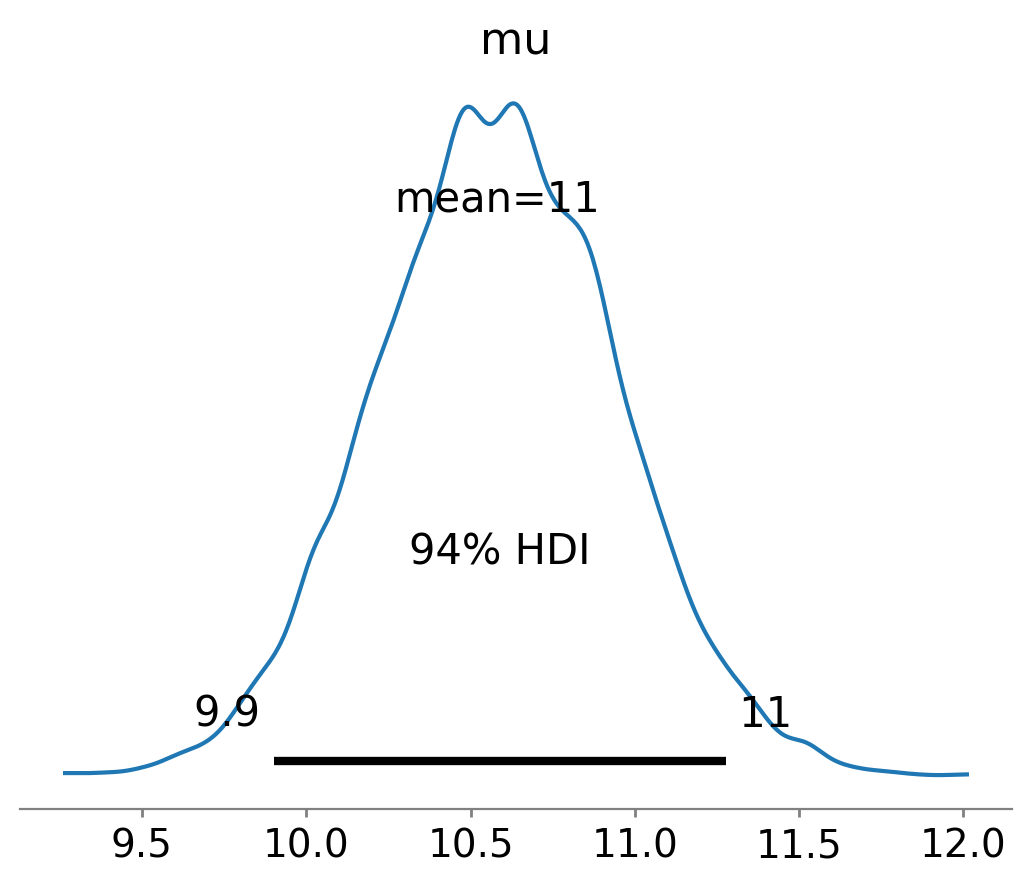

In [16]:
az.plot_posterior(idata)

In [17]:
idata.posterior['mu']

<xarray.DataArray 'mu' (chain: 4, draw: 3000)>
array([[10.481569, 10.664241,  9.584686, ..., 10.821868, 10.931216,
        10.797884],
       [10.752041, 10.780778, 10.700539, ..., 10.39983 , 10.615446,
        10.702884],
       [11.494871, 10.313757, 10.809696, ..., 10.805159, 10.078018,
        10.127686],
       [10.783266, 10.741825, 10.414527, ..., 10.268413, 10.973196,
        10.684784]], dtype=float32)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 2993 2994 2995 2996 2997 2998 2999

### 事後予測チェック PPC
モデルが上手くできているか？

In [18]:
predictive = numpyro.infer.Predictive(model, mcmc_samples)

ppc_samples = predictive(jax.random.PRNGKey(1), num_data = len(y))

In [19]:
idata_ppc = az.from_numpyro(mcmc, posterior_predictive = ppc_samples)

In [20]:
idata_ppc

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

idata_ppc ができたら確認していく

In [21]:
ppc_mean = ppc_samples['obs'].mean(axis = 1)
ppc_var = ppc_samples['obs'].var(axis = 1)

Text(0.5, 0, 'stats = var')

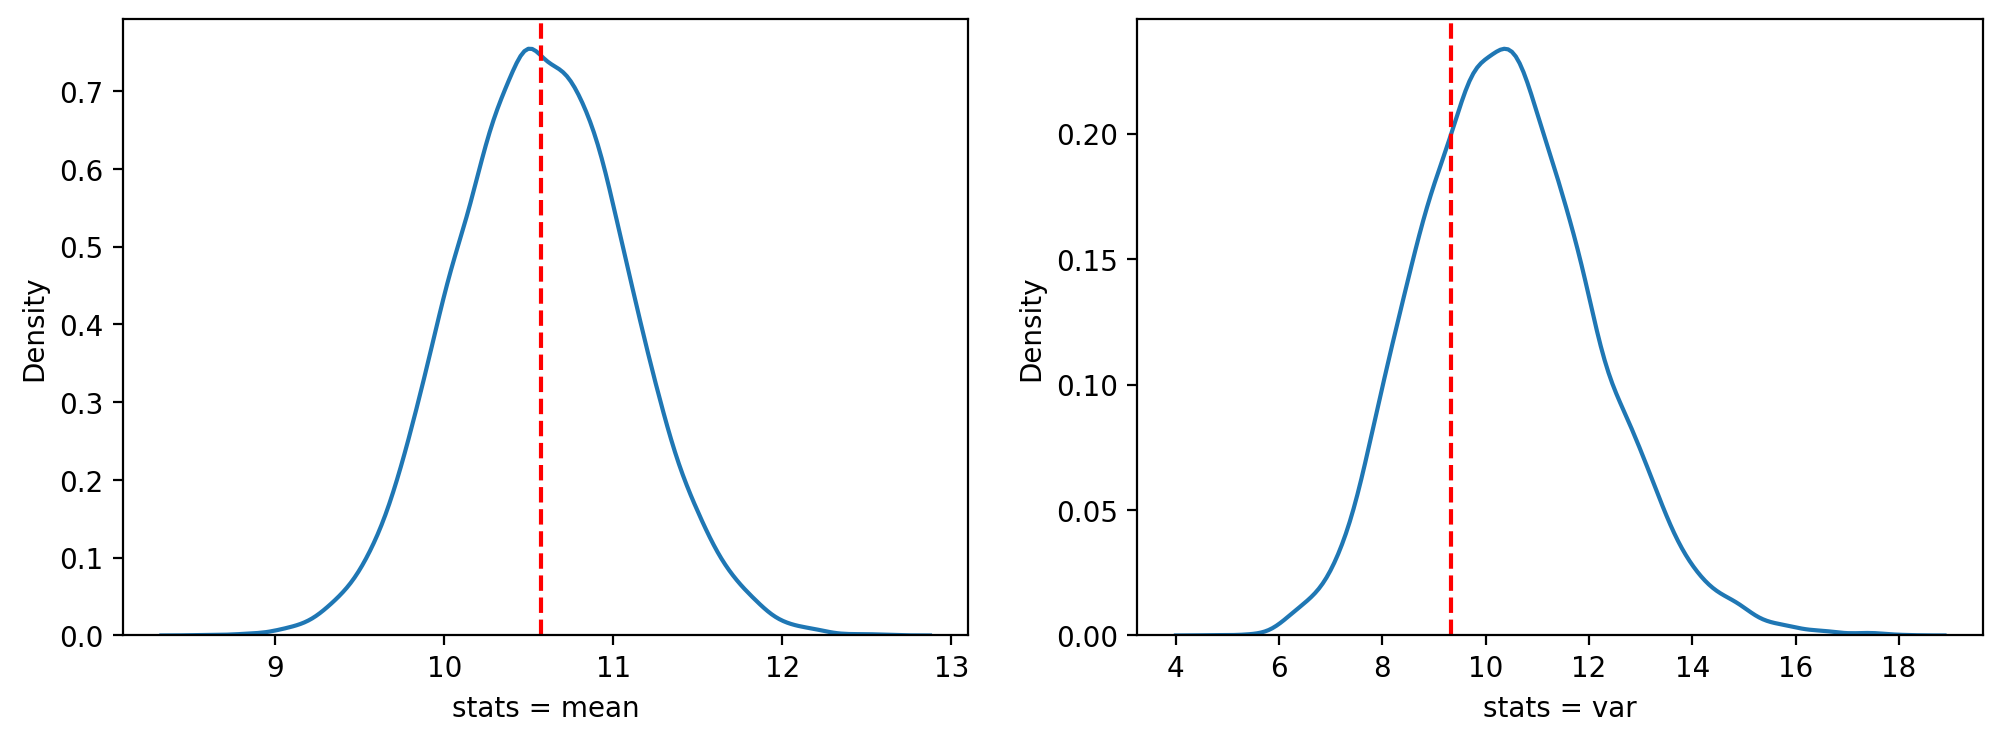

In [22]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.kdeplot(ppc_mean, ax = axes[0])
axes[0].axvline(y.mean(), color = 'r', linestyle = 'dashed')
axes[0].set_xlabel('stats = mean')

sns.kdeplot(ppc_var, ax = axes[1])
axes[1].axvline(y.var(), color = 'r', linestyle = 'dashed')
axes[1].set_xlabel('stats = var')

<Axes: xlabel='obs / obs'>

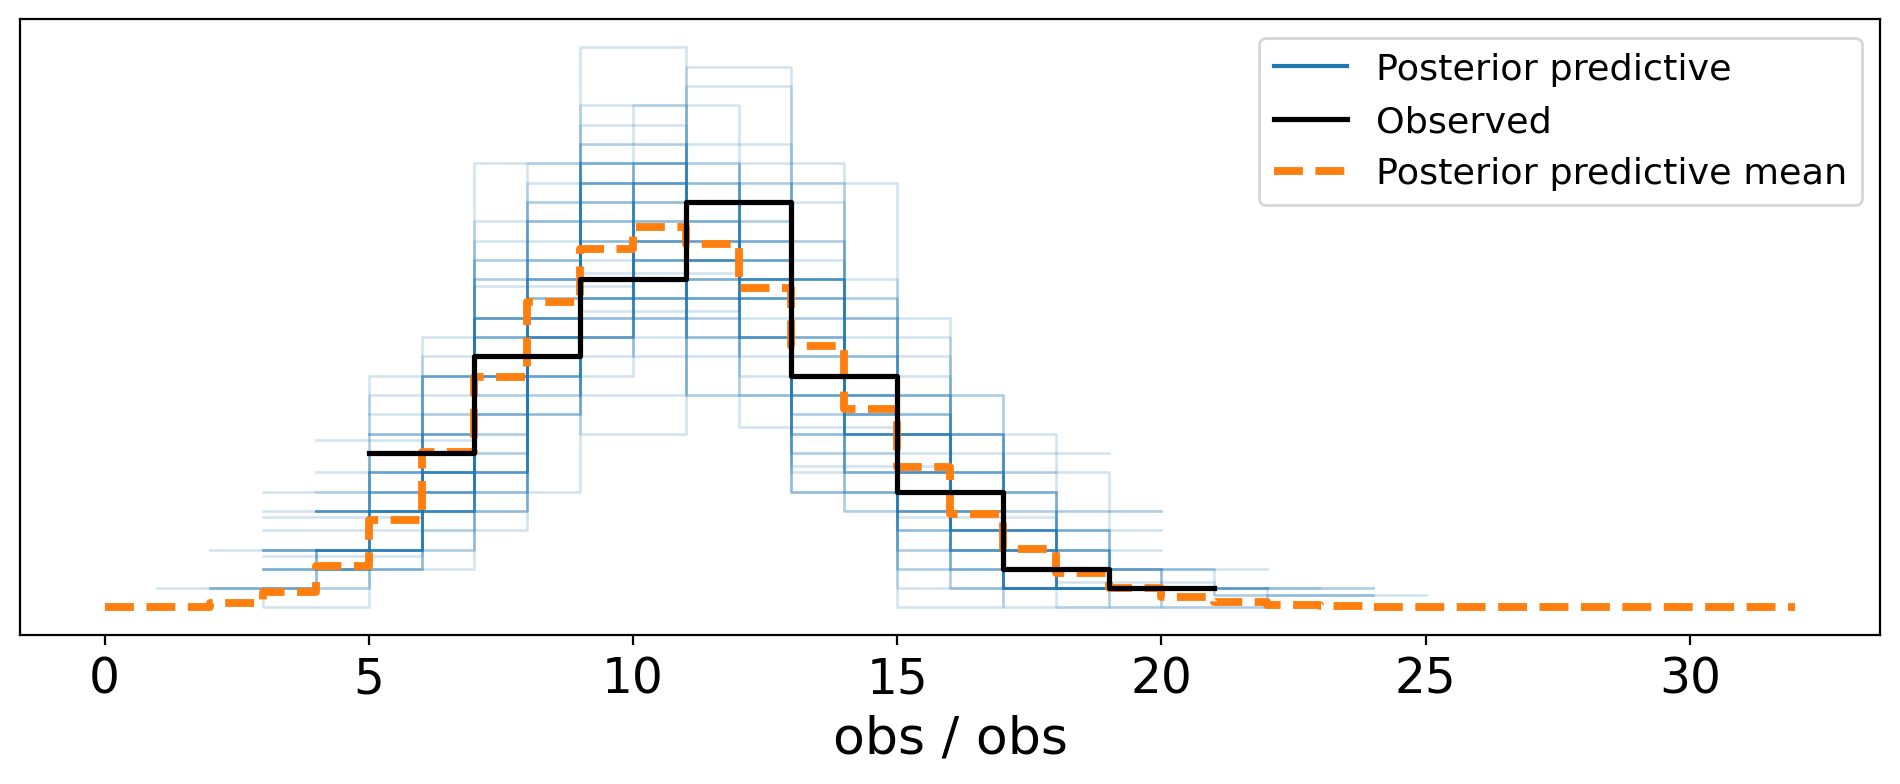

In [23]:
az.plot_ppc(idata_ppc, kind = 'kde', num_pp_samples = 50, figsize = (12, 4))

<Axes: xlabel='obs / obs'>

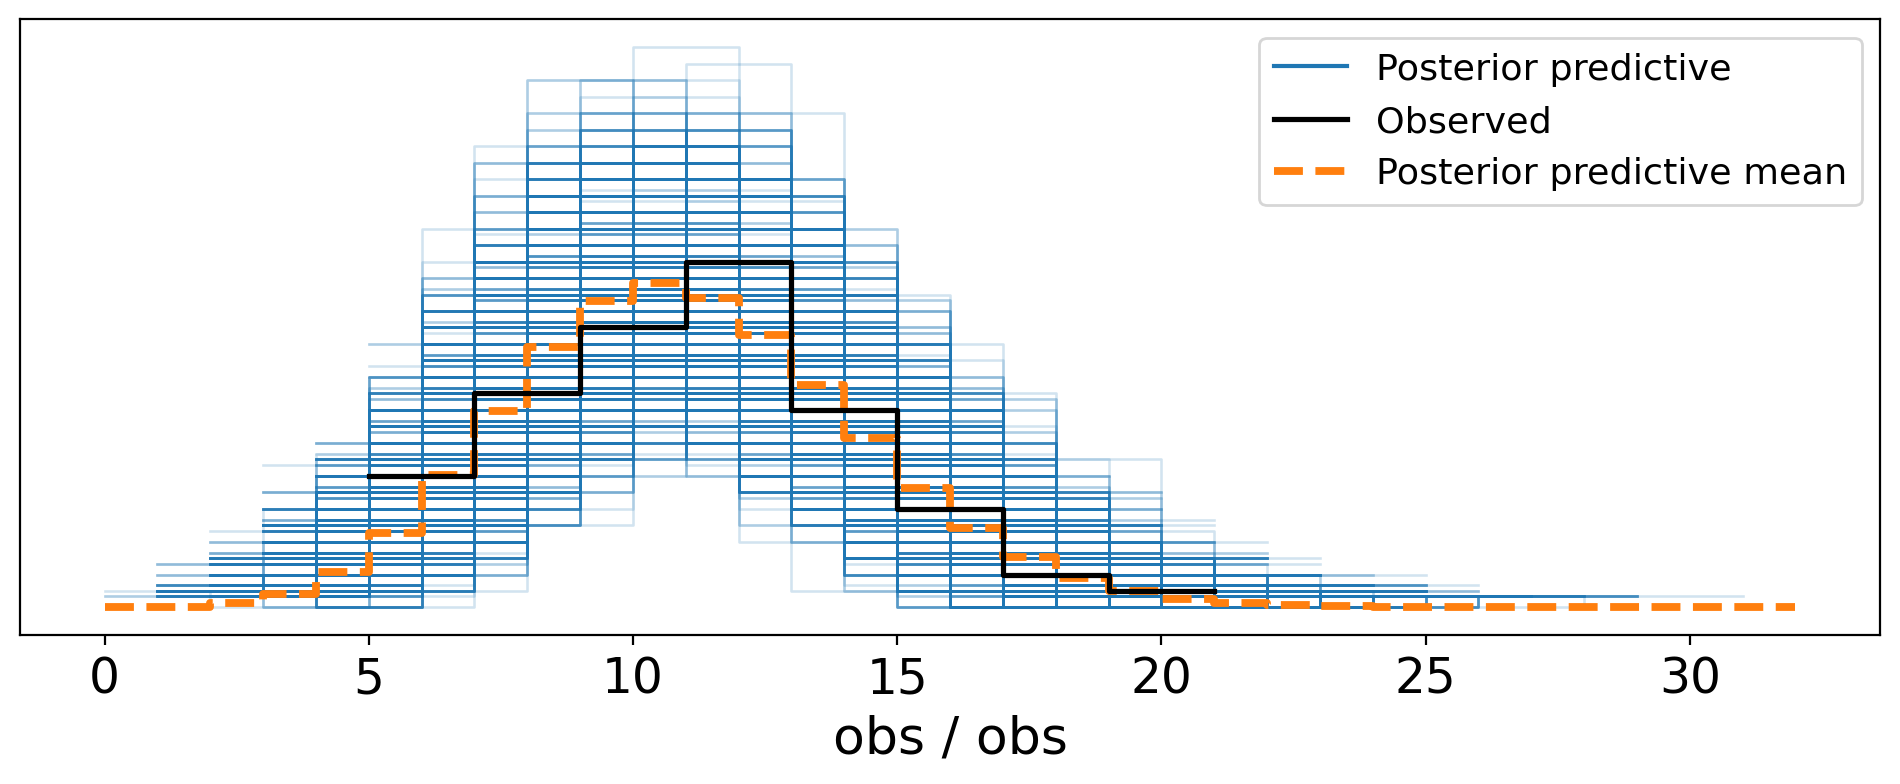

In [24]:
az.plot_ppc(idata_ppc, kind = 'kde', num_pp_samples = 3000, figsize = (12, 4))

実際のデータ（黒線ヒストグラム）が、推定したモデルから得られたサンプリング（3000本の青線ヒストグラム）に埋もれているから大丈夫そうですね、という話

### A/B 比較について

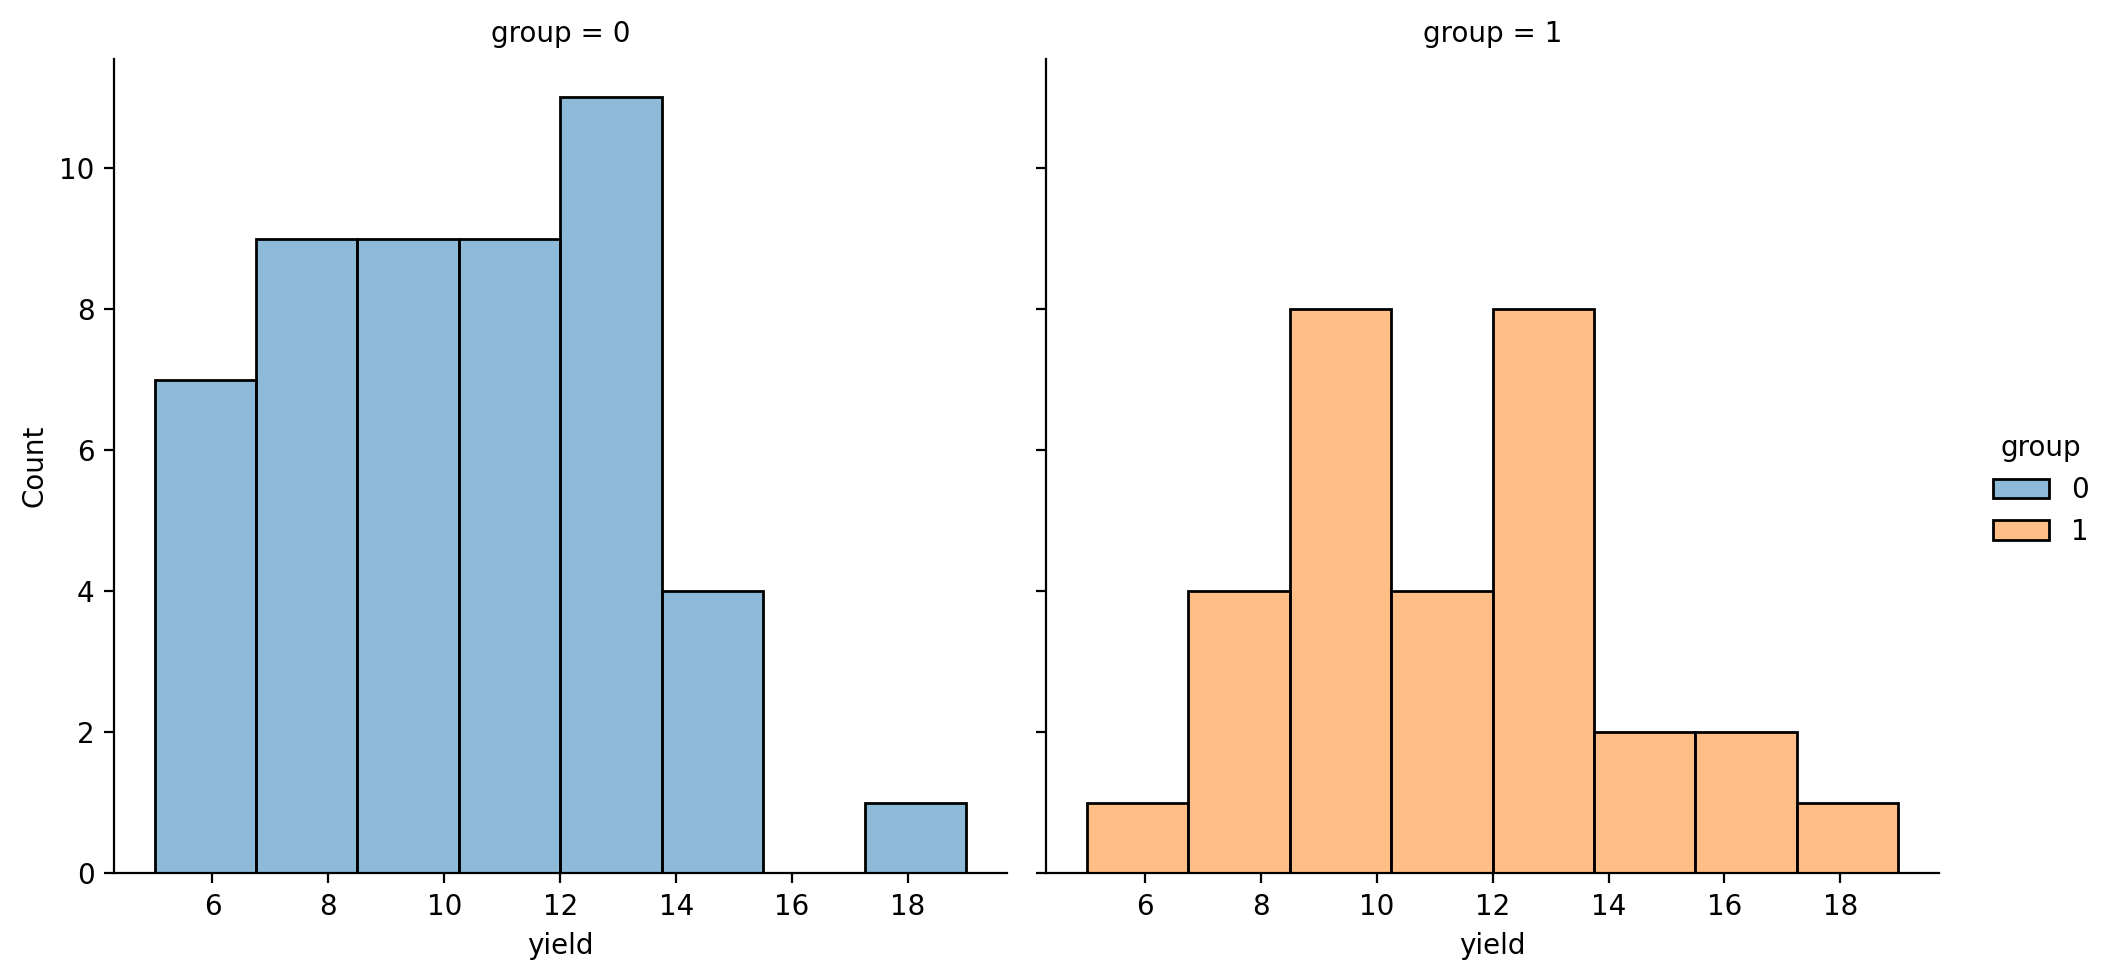

In [25]:
sns.displot(data = data, x = 'yield', hue = 'group', col = 'group')

In [26]:
data.groupby('group').mean()

,yield
group,
0,10.160000
1,11.266667


In [27]:
y = data['yield'].values
g = data['group'].values

In [28]:
def model(y = None, g = None, num_data = 0):
    mu = numpyro.sample('mu', dist.HalfNormal(10), sample_shape = (2,))

    mu_dup = mu[g]

    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Poisson(mu_dup), obs = y)

    mu_diff = numpyro.deterministic('mu_diff', mu[1] - mu[0])

In [29]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)

mcmc.run(jax.random.PRNGKey(0), y = y, g = g, num_data = len(y))

/var/folders/03/smvv0jp54c5cnt0xtqz_1gkc0000gn/T/ipykernel_86750/510268806.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)
sample: 100%|█| 3500/3500 [00:00<00:00, 3928.35it/s, 19 steps of size 8.73e-01. acc. prob=
sample: 100%|█| 3500/3500 [00:00<00:00, 12239.34it/s, 3 steps of size 9.10e-01. acc. prob=
sample: 100%|█| 3500/3500 [00:00<00:00, 12126.04it/s, 3 steps of size 7.82e-01. acc. prob=
sample: 100%|█| 3500/3500 [00:00<00:00, 12162.79it/s, 3 steps of size 7.84e-01. acc. prob=


In [30]:
mcmc_samples = mcmc.get_samples()

In [31]:
idata = az.from_numpyro(mcmc)

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'mu_diff'}>,
        <Axes: title={'center': 'mu_diff'}>]], dtype=object)

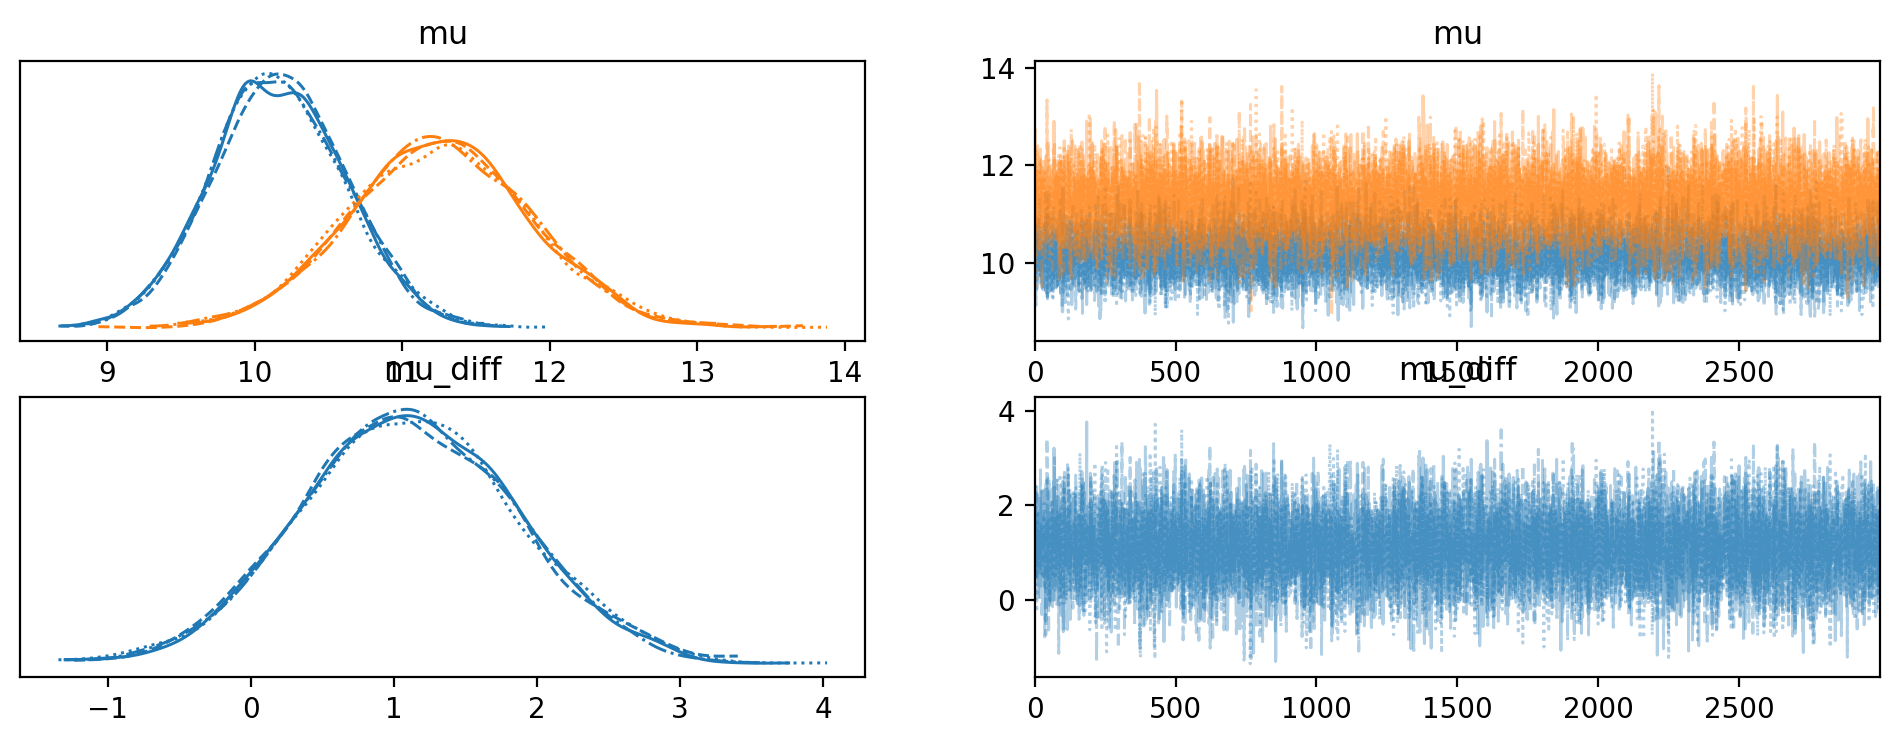

In [32]:
az.plot_trace(idata)

### A/Bのパラメーターを比較する

Text(0.5, 0, '$\\lambda_1 - \\lambda_0$')

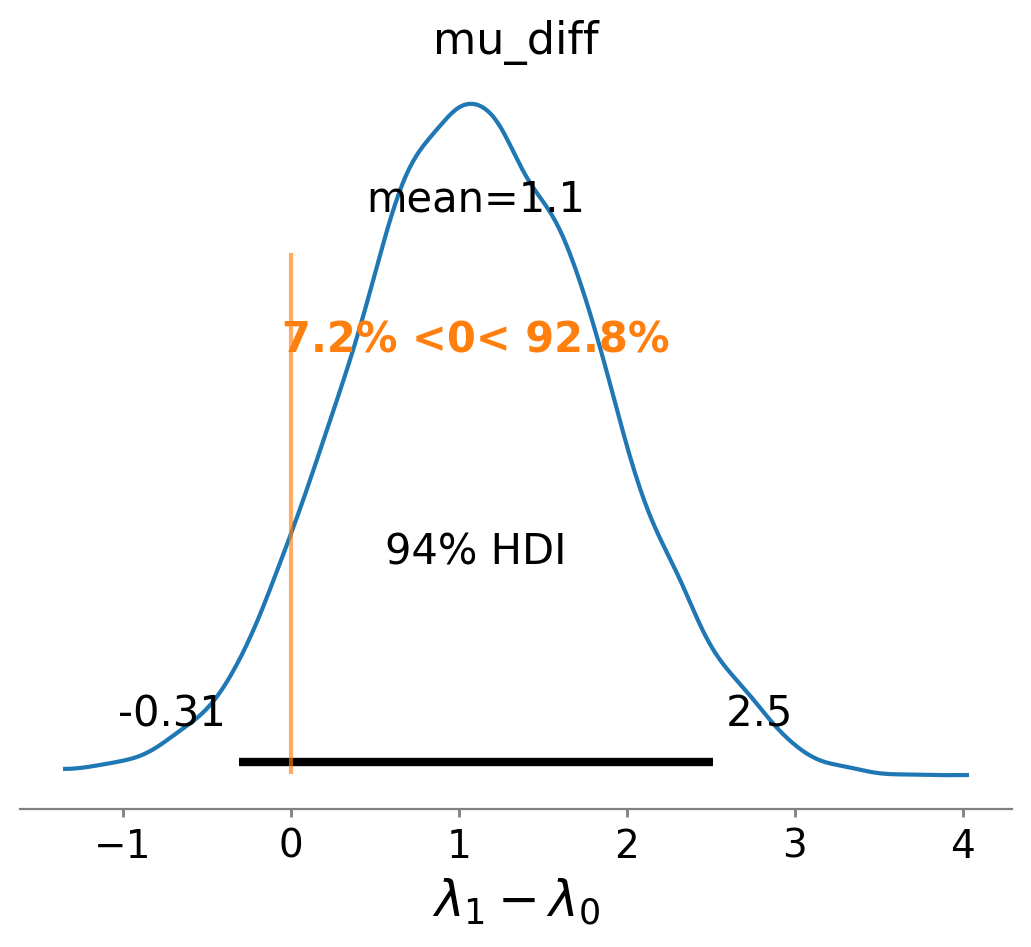

In [33]:
az.plot_posterior(idata, var_names = ['mu_diff'], ref_val = 0) 
plt.xlabel('$\lambda_1 - \lambda_0$', fontsize = 18)

### ポイント
ここでベイズの旨み。有意水準だと5％ないので有意と言えない、となってしまうが、実際にはこんな形の差になりそうだという分布が出てくるので直感的に理解しやすい

# ゼロ過剰ポワソン

In [34]:
data_2 = pd.DataFrame({
    'yield':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 3, 0, 2, 0, 2,
             0, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 3, 0,
             1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'group':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
             1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
})

In [35]:
y_2 = data_2['yield'].values
g_2 = data_2['group'].values

In [36]:
np.mean(y_2)

0.375

In [37]:
np.var(y_2)

0.484375

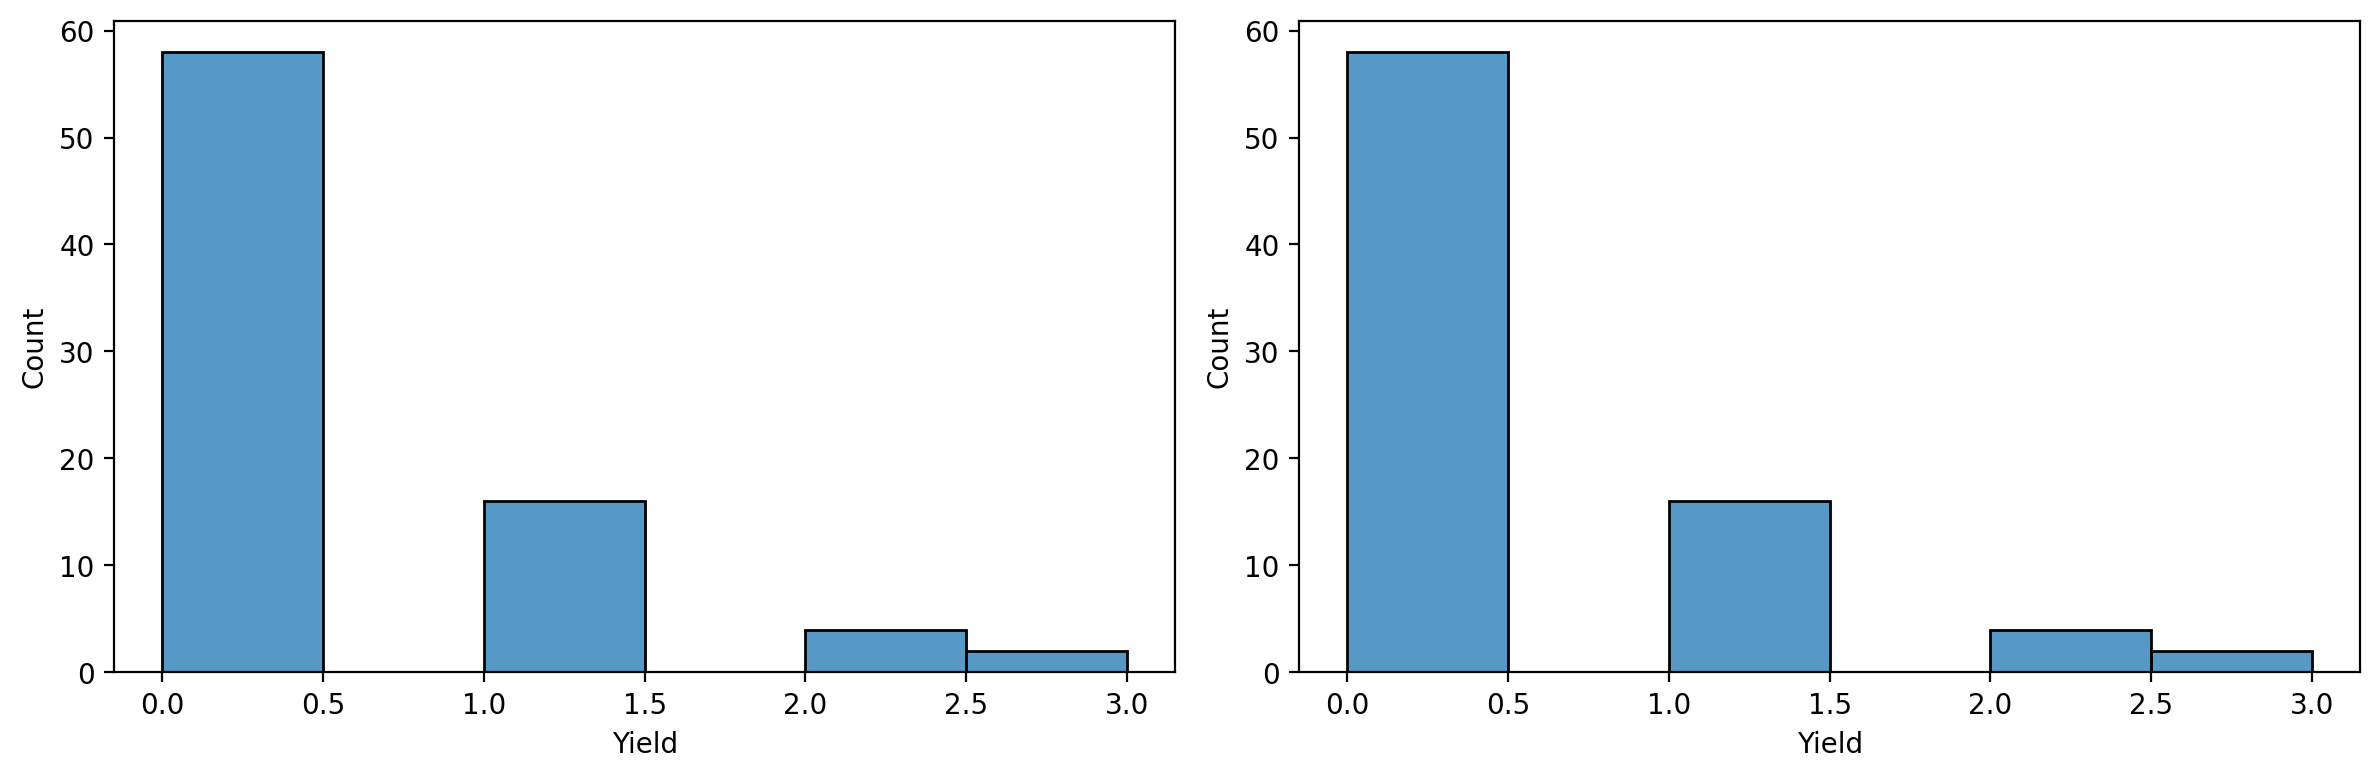

In [38]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(y_2, binwidth = 0.5, ax = axes[0])
axes[0].set_xlabel('Yield')

sns.histplot(y_2, binwidth = 0.5, ax = axes[1])
axes[1].set_xlabel('Yield')

plt.tight_layout()

In [39]:
def model_2(y = None, g = None, num_data = 0):

    psi = numpyro.sample('psi', dist.Uniform(low = 0.0, high = 1.0), sample_shape = (2,))
    lam = numpyro.sample('mu', dist.HalfNormal(10), sample_shape = (2,))

    psi_dup = psi[g]
    lam_dup = lam[g]

    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.ZeroInflatedPoisson(psi_dup, rate = lam_dup), obs = y)

    psi_diff = numpyro.deterministic('psi_diff', psi[1] - psi[0])
    lam_diff = numpyro.deterministic('lam_diff', lam[1] - lam[0])

In [40]:
nuts = numpyro.infer.NUTS(model_2)
mcmc_2 = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)

mcmc_2.run(jax.random.PRNGKey(0), y = y_2, g = g_2, num_data = len(y_2))

/var/folders/03/smvv0jp54c5cnt0xtqz_1gkc0000gn/T/ipykernel_86750/1948037407.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_2 = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)
sample: 100%|█| 3500/3500 [00:01<00:00, 3209.26it/s, 3 steps of size 4.19e-01. acc. prob=0
sample: 100%|█| 3500/3500 [00:00<00:00, 10628.73it/s, 7 steps of size 4.29e-01. acc. prob=
sample: 100%|█| 3500/3500 [00:00<00:00, 10667.05it/s, 7 steps of size 4.59e-01. acc. prob=
sample: 100%|█| 3500/3500 [00:00<00:00, 10354.85it/s, 15 steps of size 3.32e-01. acc. prob


In [41]:
mcmc_samples_2 = mcmc_2.get_samples()

In [42]:
idata_2 = az.from_numpyro(mcmc_2)

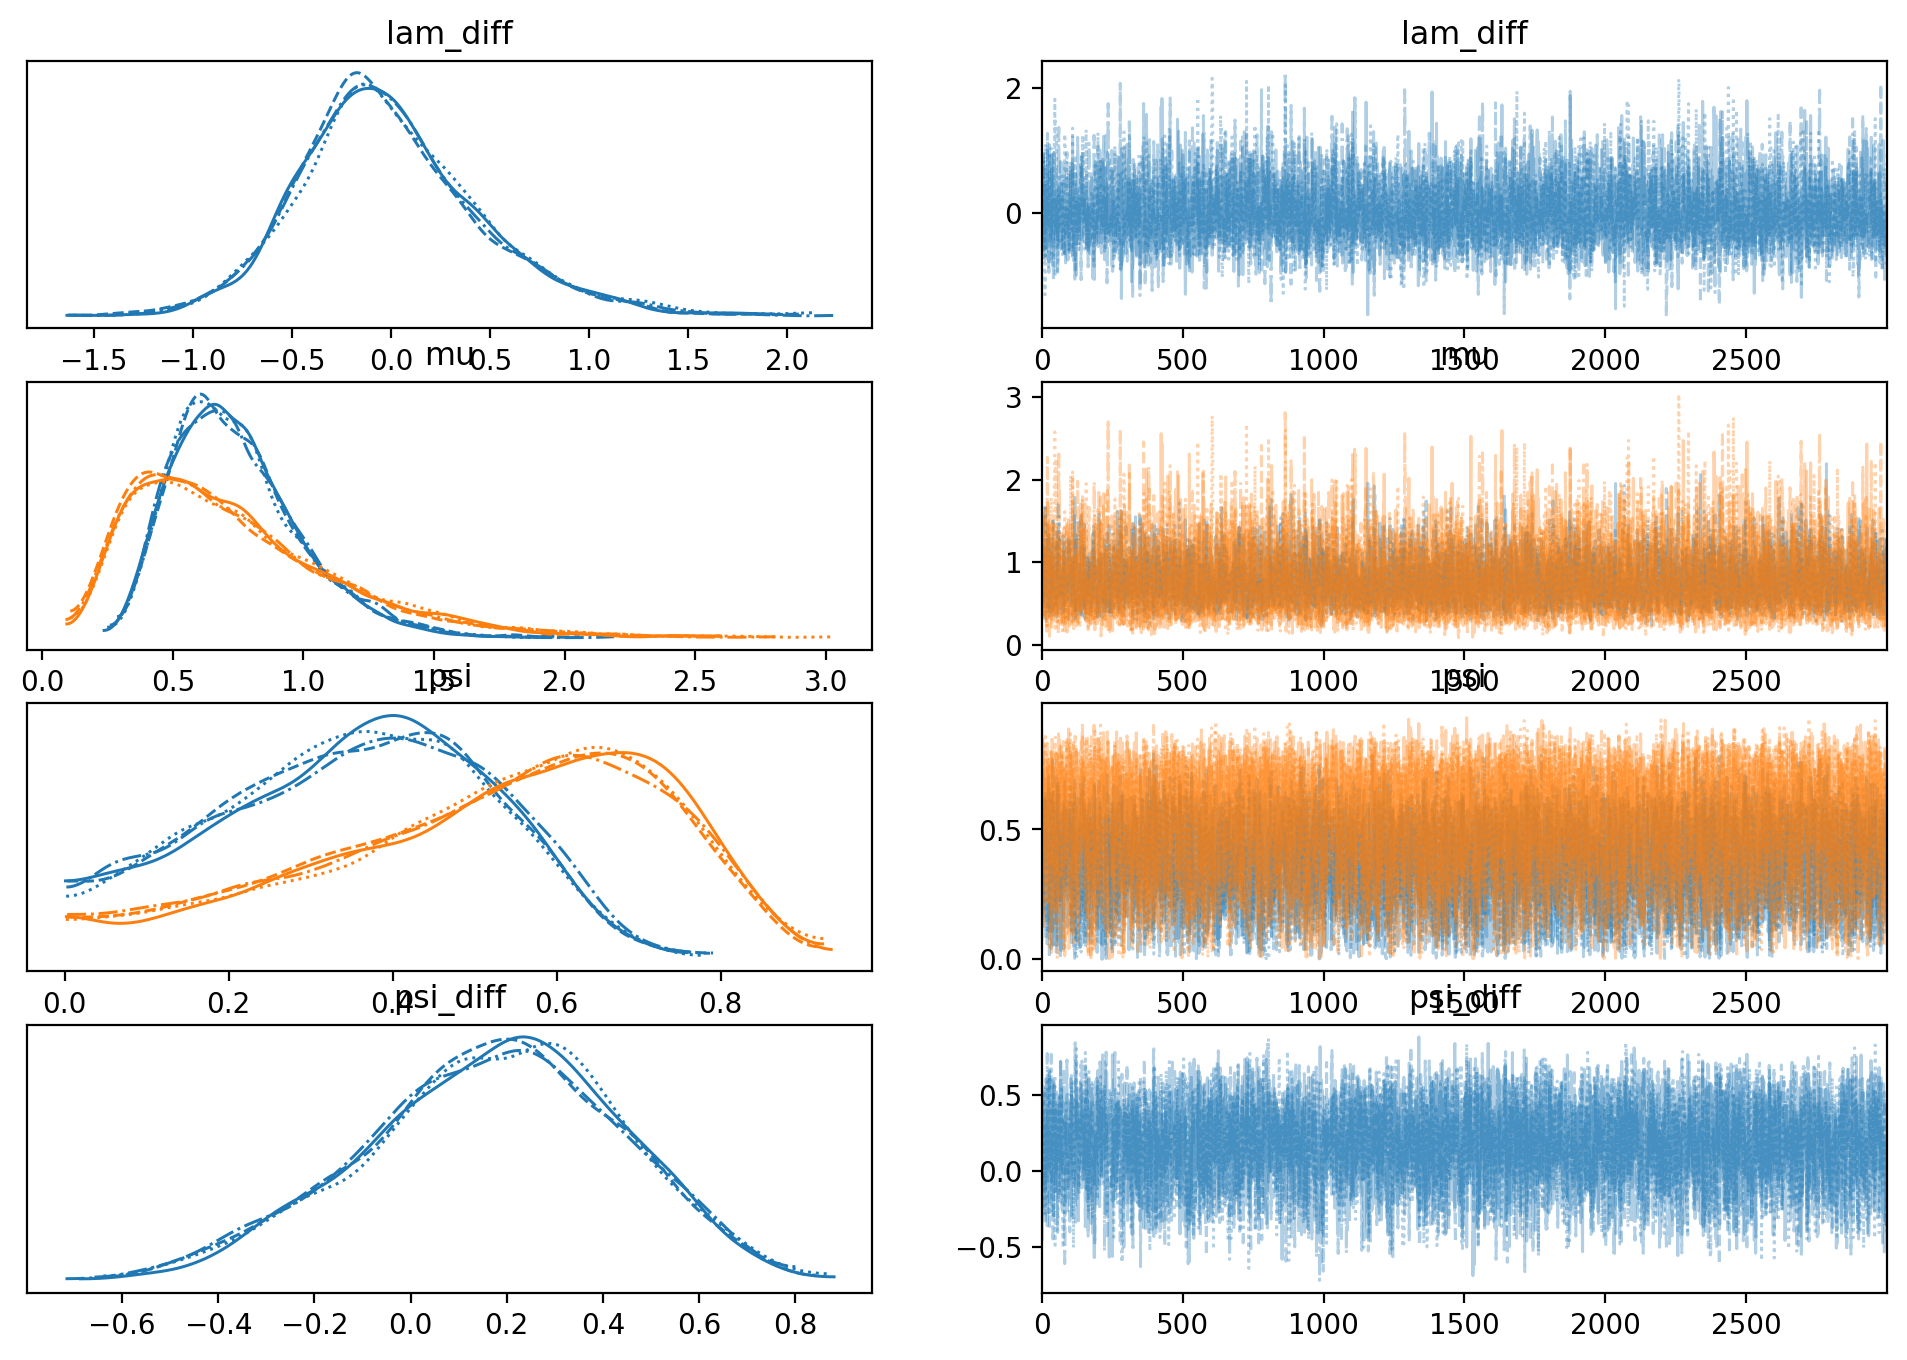

In [43]:
az.plot_trace(idata_2);

事後予測チェック

Text(0.5, 0, '$\\psi_1 - \\psi_0$')

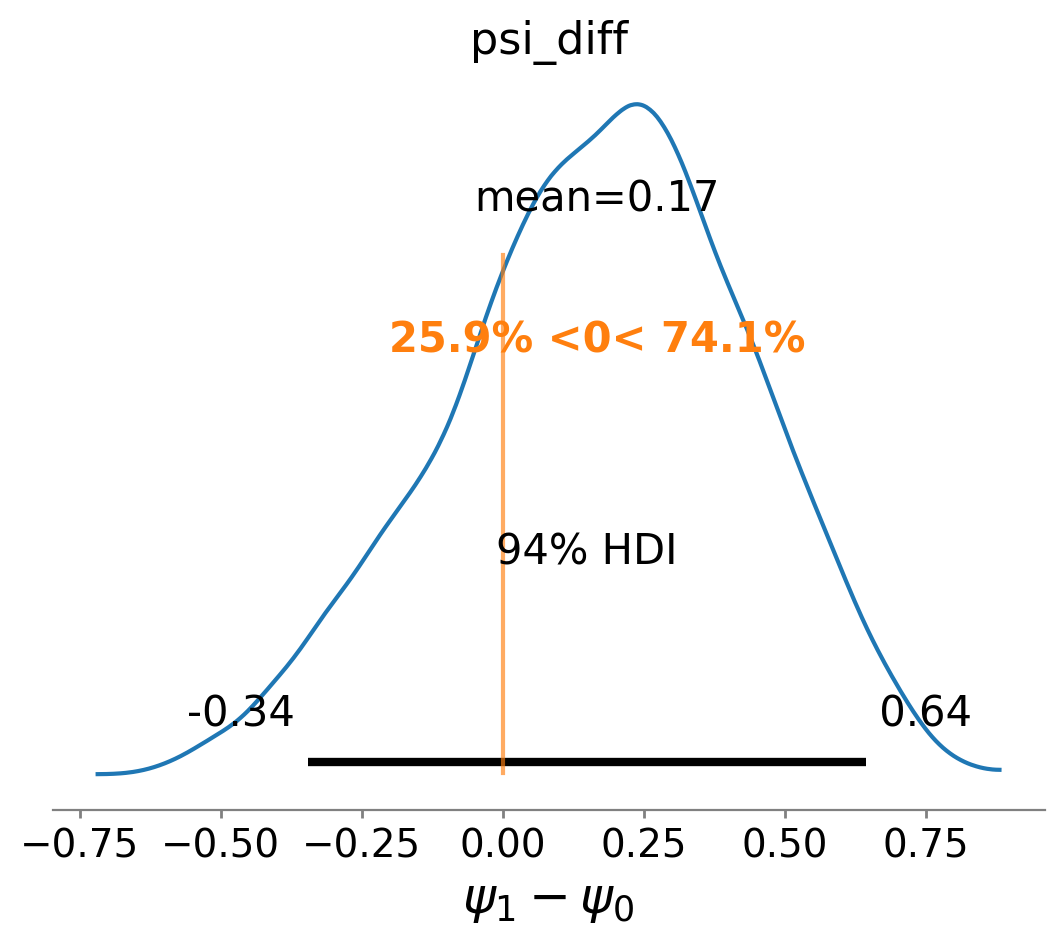

In [44]:
az.plot_posterior(idata_2, var_names = ['psi_diff'], ref_val = 0) 
plt.xlabel('$\psi_1 - \psi_0$', fontsize = 18)

Text(0.5, 0, '$\\lambda_1 - \\lambda_0$')

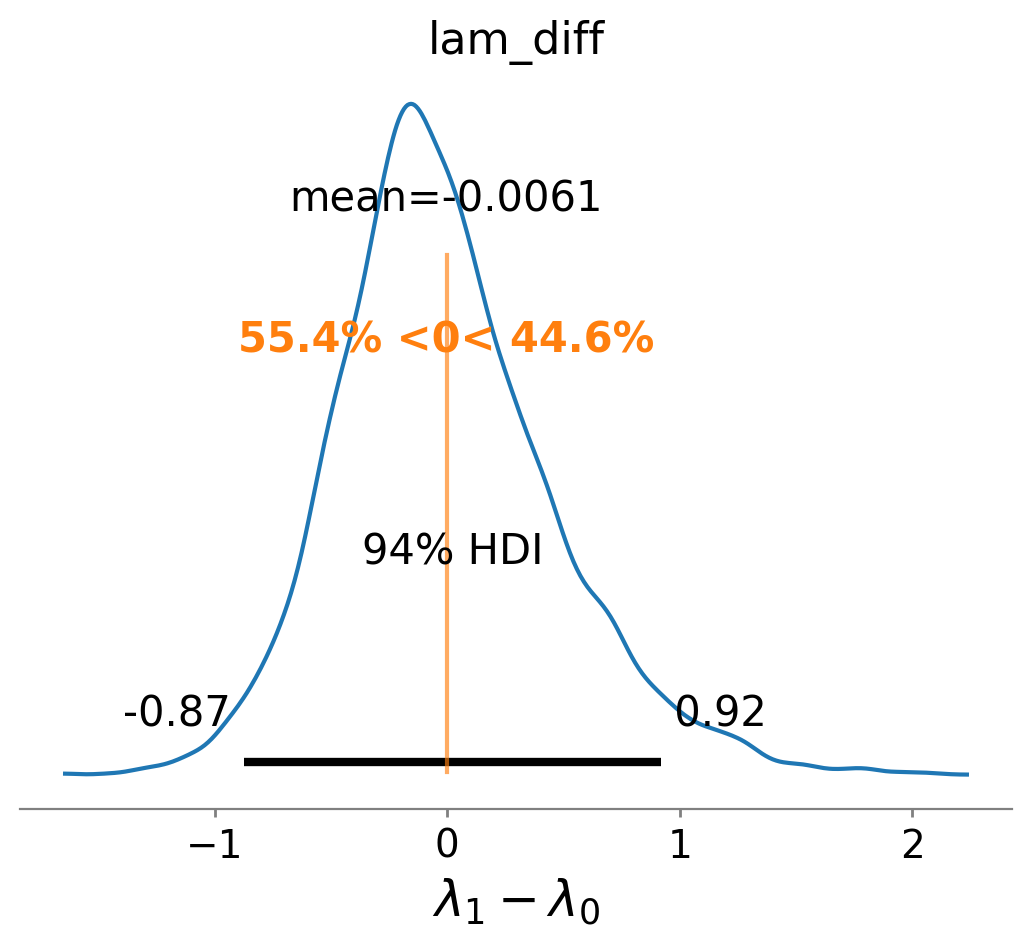

In [45]:
az.plot_posterior(idata_2, var_names = ['lam_diff'], ref_val = 0) 
plt.xlabel('$\lambda_1 - \lambda_0$', fontsize = 18)

### 情報基準（WAIC）

In [53]:
az.waic(idata, scale = 'deviance')

Computed from 12000 posterior samples and 80 observations log-likelihood matrix.

              Estimate       SE
deviance_waic   406.81     9.97
p_waic            1.70        -

In [54]:
az.waic(idata_2, scale = 'deviance')

/Users/kazutak/Git/AB_test/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 12000 posterior samples and 80 observations log-likelihood matrix.

              Estimate       SE
deviance_waic   134.53    17.16
p_waic            3.53        -

There has been a warning during the calculation. Please check the results.

In [48]:
dict_idata = {'Poisson':idata, 'ZeroInfPoisson': idata_2}

df_waic = az.compare(dict_idata, ic = 'waic', scale = 'deviance')

/Users/kazutak/Git/AB_test/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kazutak/Git/AB_test/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/kazutak/Git/AB_test/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'deviance' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


In [55]:
df_waic

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
ZeroInfPoisson,0,134.527513,3.531780,0.000000,1.0,17.162808,0.000000,True,deviance
Poisson,1,406.811081,1.704659,272.283568,0.0,9.974378,18.912842,False,deviance


/Users/kazutak/Git/AB_test/.venv/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

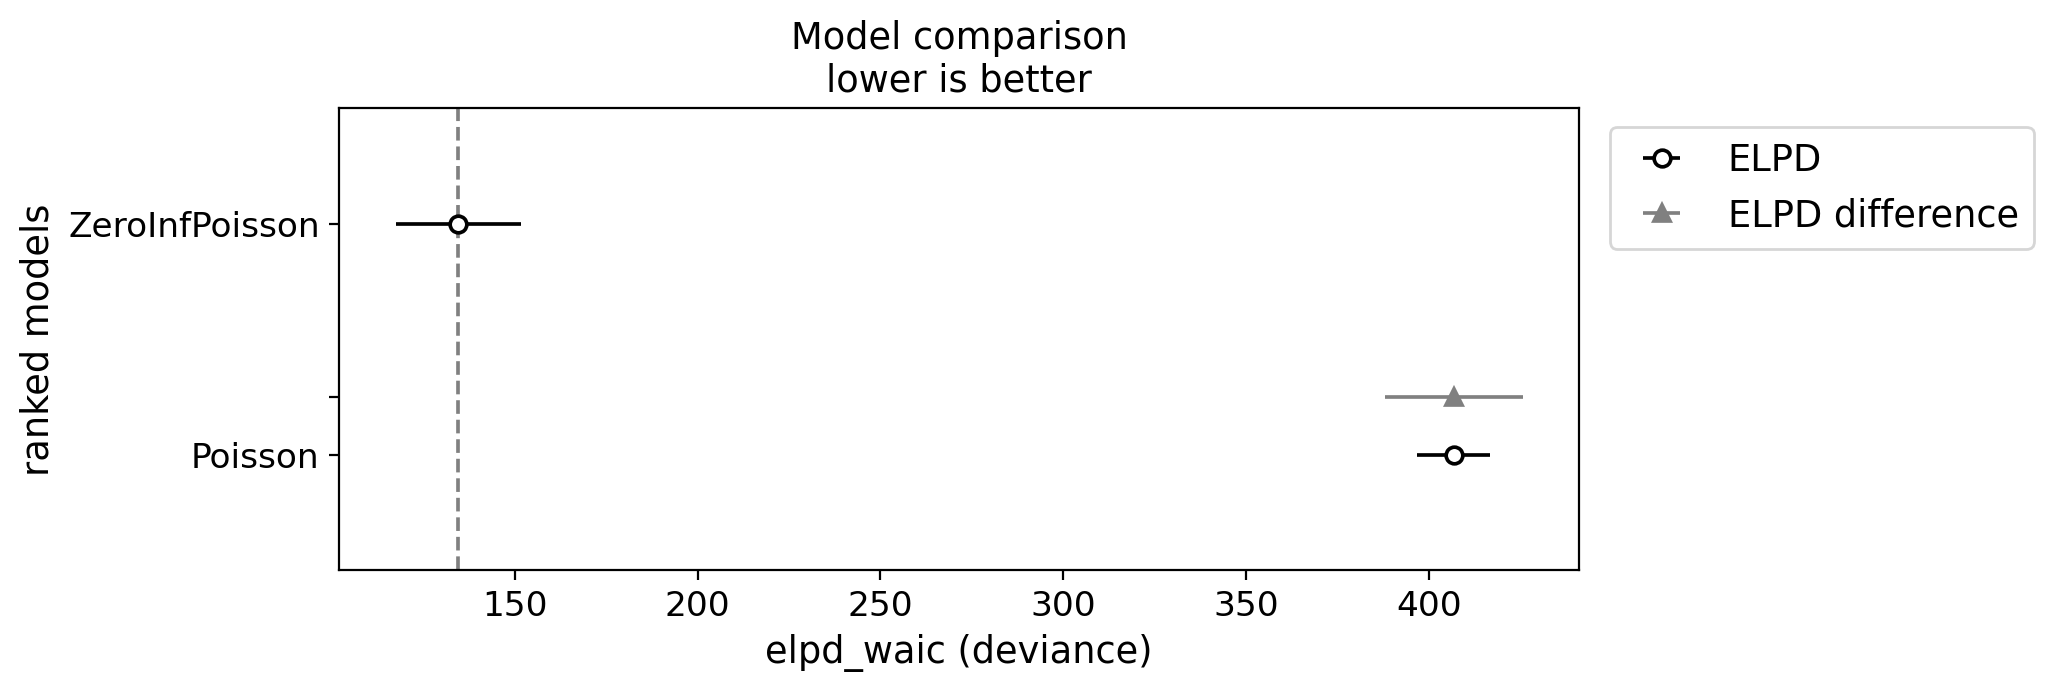

In [50]:
az.plot_compare(df_waic, figsize = (8,3))

# 線形回帰

In [58]:
# 全体の値に対して線形回帰を行う場合

def model_linear(x_scaled = None, y_scaled = None, num_data = 0):
    a = numpyro.sample('a', dist.Normal(0, 10))
    b = numpyro.sample('b', dist.Normal(0, 10))

    mu = a * x_scale + b # 線形回帰式

    sa = numpyro.sample('sd', dist.HalfCauchy(5))

    with nupyro.plate('data', num_data):
        numpyro.sample('obs', dist.Normal(mu, sd), obs = y_scaled)

In [57]:
# ex. 男女の値に対して線形回帰を行う場合

def model_linear_2_groups(x_scaled = None, y_scaled = None, group = None, num_data = 0):
    a = numpyro.sample('a', dist.Normal(0, 10), sample_shape = (2,))
    b = numpyro.sample('b', dist.Normal(0, 10), sample_shape = (2,))

    mu = a[group] * x_scaled + b[group] # 線形回帰式

    sa = numpyro.sample('sd', dist.HalfCauchy(5))

    with nupyro.plate('plate_obs', num_data):
        numpyro.sample('obs', dist.Normal(mu, sd), obs = y_scaled)